In [32]:
from qiskit import *

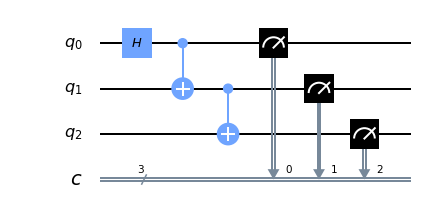

In [33]:
nqubits = 3
circuit = QuantumCircuit(nqubits, nqubits)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.measure([0,1,2],[0,1,2])
%matplotlib inline
circuit.draw(output='mpl')

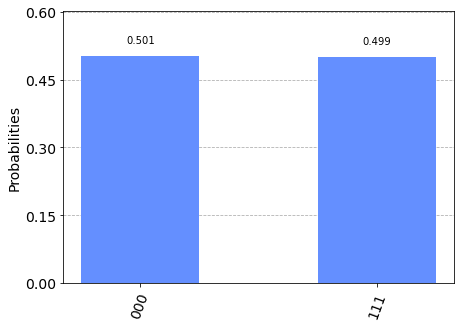

In [34]:
simulator = Aer.get_backend('qasm_simulator')
sim_result = execute(circuit, backend=simulator, shots=1024).result()
from qiskit.tools.visualization import plot_histogram
plot_histogram(sim_result.get_counts(circuit))

In [35]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
device = provider.get_backend('ibmqx2')

ibmqfactory.load_account:WARNING:2020-05-20 10:57:32,973: Credentials are already in use. The existing account in the session will be replaced.


In [37]:
job = execute(circuit, backend=device, shots=1024)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

5ec48f120644600014c813f4
Job Status: job has successfully run


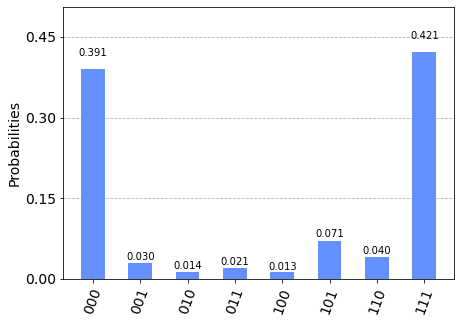

In [38]:
device_result = job.result()
plot_histogram(device_result.get_counts(circuit))

# Measurement Error Mitigation
Perhatikan bahwa 2 gambar histogram plot di atas sedikit berbeda. 
Plot pertama = hasil simulasi Qiskit Aer di lokal laptop kita, mensimulasikan kondisi ideal komputasi tanpa error / noise.
Plot kedua = hasil komputasi di real quantum device milik IBM, ada sedikit error karena noise.

Saat ini quantum device masih dalam tahap penyempurnaan oleh tim peneliti IBM, sehingga sedikit demi sedikit noise dan error tsb akan bisa dikurangi, untuk menuju ke kondisi ideal tanpa noise dan error seperti pada simulator Aer di laptop kita.

"How small error in quantum computation introduce measurement results that take us far away from an ideal quantum computer would give us.
We use Qiskit Ignis to understand what those kinds of errors are, and to find out what the parameters involved are to generate a fitter, and then to use that fitter to generate a filter which allowed us to mitigate the errors in our measurement outcome."
sumber YouTube = https://www.youtube.com/watch?v=yuDxHJOKsVA&list=PLOFEBzvs-Vvp2xg9-POLJhQwtVktlYGbY&index=8

Solusi utk permasalahan error/noise ini, kita buat filter untuk menyaring hasil dari komputasi di real quantum device, dengan menggunakan Qiskit Ignis.

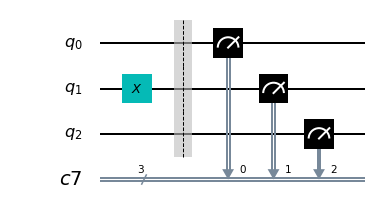

In [49]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr = circuit.qregs[0], circlabel = 'measerrormitigationcal')
cal_circuits[2].draw(output='mpl')

In [40]:
len(cal_circuits)

8

In [41]:
cal_job = execute(cal_circuits, 
                 backend = device,
                  shots = 1024,
                  optimization_level = 0
                 )
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

5ec48fabd6ae610013e68d06
Job Status: job has successfully run


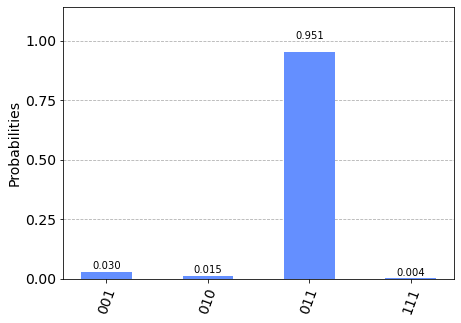

In [42]:
plot_histogram(cal_results.get_counts(cal_circuits[3]))

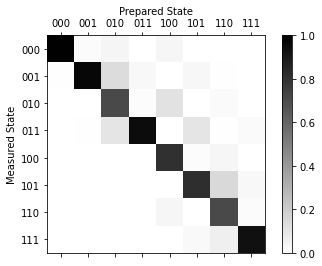

In [43]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_fitter.plot_calibration()

In [50]:
# di titik ini, proses fitting selesai, dan kemudian kita membuat filter 
# utk nanti nya bisa dipakai me mitigasi error/noise pada kalkulasi di real quantum device
meas_filter = meas_fitter.filter

In [51]:
mitigated_result = meas_filter.apply(device_result)

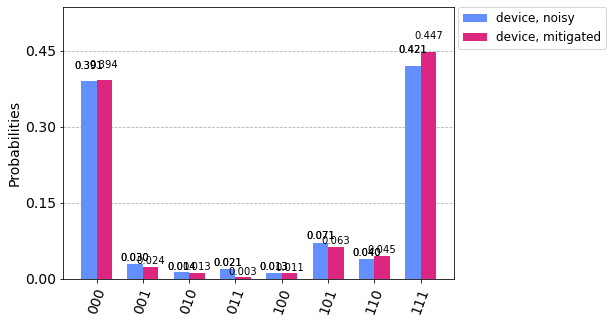

In [52]:
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], legend=['device, noisy','device, mitigated'])

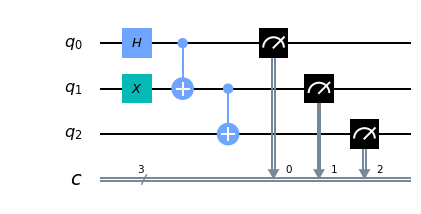

In [53]:
# mari kita coba lagi filternya utk circuit baru
circuit2 = QuantumCircuit(3,3)
circuit2.x(1)
circuit2.h(0)
circuit2.cx(0,1)
circuit2.cx(1,2)
circuit2.measure([0,1,2],[0,1,2])
circuit2.draw(output='mpl')

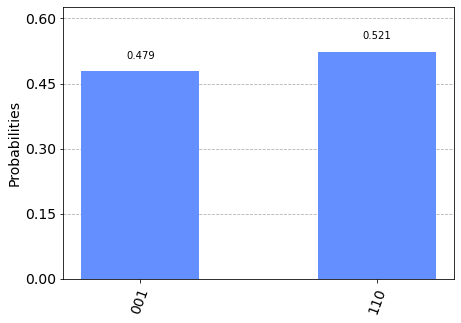

In [54]:
plot_histogram(
execute(circuit2, backend=simulator, shots=1024).result().get_counts(circuit2)
)

In [56]:
job = execute(circuit2, backend=device, shots=1024)
job_monitor(job)
device_counts2 = job.result().get_counts(circuit2)

Job Status: job has successfully run


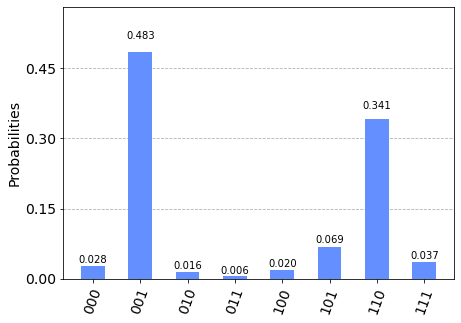

In [57]:
plot_histogram(device_counts2)

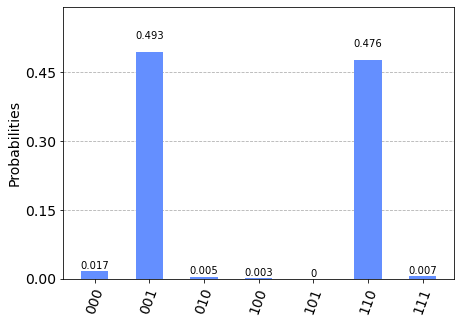

In [59]:
# perhatikan plot diatas ada banyak noise/error, selain dari hasil simulasi pada kondisi ideal yg hanya 000 dan 110
# mari kita coba pakai filter utk me reduksi error/noise
device_mitigated_counts_2 = meas_filter.apply(device_counts2)
plot_histogram(device_mitigated_counts_2)